## <center> Solutions for Relax Inc. Take-home Challenge <center>

In [239]:
######################
# Importing packages
######################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import timedelta
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from tqdm import tqdm
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

### 1. Data wrangling

In [240]:
##################################
# Load two tables from csv files
##################################
user0=pd.read_csv('takehome_users.csv')
usage_summary0=pd.read_csv('takehome_user_engagement.csv')

In [241]:
######################################################
# Clean and wrangle data
# For invited by user id, impute 0 for unknown users
######################################################
user1=user0[['object_id']]
user1['creation_time']=user0['creation_time'].apply(pd.to_datetime)
user1['creation_source']=user0['creation_source']
user1['last_session_creation_time']=user0['last_session_creation_time'].apply(
    lambda x: pd.to_datetime(datetime.fromtimestamp(x)) if not np.isnan(x) else np.nan)
for i in range(6, 9):
    user1[user0.columns[i]]=user0.iloc[:, i]
user1['invited_by_user_id']=user0['invited_by_user_id'].fillna(0).apply(lambda x: int(x))
usage_summary=usage_summary0[['user_id']]
usage_summary['time_stamp']=usage_summary0['time_stamp'].apply(pd.to_datetime)

In [242]:
####################################################################
# Impute the missing last session creation time with creation time
####################################################################
user1.last_session_creation_time[user1.last_session_creation_time.isnull()]=user1.creation_time

In [243]:
####################################################################
# Define "adopted user" as a user who has logged into the product
# on three separate days in at least one seven-day period.
# This is the dependent variable
####################################################################
def is_adopted_user(timestamp_list):
    """Tell if a user is adopted user."""
    from datetime import timedelta
    timestamp_list_sorted=sorted(timestamp_list)
    if len(timestamp_list_sorted)<3:
        return 0
    else:
        for i in range(len(timestamp_list_sorted)-2):
            first_login_date=pd.to_datetime(timestamp_list_sorted[i].strftime('%Y-%m-%d'))
            third_login_time=timestamp_list_sorted[i+2]
            end_of_seven_day_period=first_login_date+timedelta(days=7)
            if third_login_time<end_of_seven_day_period:
                return 1
    return 0
######################################################################

In [244]:
adopted=usage_summary.groupby(by=['user_id']).agg(is_adopted_user).rename(columns={'time_stamp': 'adopted'})

In [245]:
####################################################
# Join the adopted column to the user data frame
# Fill NaN with 0
####################################################
user2=user1.set_index('object_id')
user2=user2.rename_axis('user_id')
user3=user2.join(adopted, how='left').fillna(0)
user=user3.copy()
user.adopted=user3.adopted.astype('int64')

In [246]:
##################################
# Data types are good
##################################
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  12000 non-null  datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          12000 non-null  int64         
 7   adopted                     12000 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 1.1+ MB


In [247]:
#######################################
# There is no missing data
#######################################
user.isnull().sum()

creation_time                 0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adopted                       0
dtype: int64

### 2. Feature Engineering

In [248]:
##################################################
# Extract features for modeling 
# (start categorical)
##################################################
# Creation source one-hot encoding
##################################################
y=user['adopted']
X=pd.get_dummies(user[['creation_source']])
##################################################
# Copy mailing list and marketing drip columns
##################################################
X['opted_in_to_mailing_list']=user['opted_in_to_mailing_list']
X['enabled_for_marketing_drip']=user['enabled_for_marketing_drip']
######################################################################
# The group each user belongs to
######################################################################
group=pd.get_dummies(user[['org_id']].astype('category'))
X=X.join(group, how='left')
######################################################################
# The invite user each user was invited
######################################################################
invite_user=pd.get_dummies(user[['invited_by_user_id']].astype('category'))
X=X.join(invite_user, how='left')
######################################################################
# If users are inviters
######################################################################
inviters=set([ele[0] for ele in user[['invited_by_user_id']].values.tolist()])
X['is_inviter']=0
for single_user in user.index:
    if single_user in inviters:
        X.loc[single_user, 'is_inviter']=1
######################################################################
# The size of the group each user belongs to 
# (start numerical)
######################################################################
group_size=user[['org_id']].value_counts()
X['org_size']=user['org_id'].apply(lambda x: group_size[x])
##################################################
# days between creation and last session
##################################################
import timedelta
X['days_between_creation_and_last_session']=0
for index in X.index:
    days=timedelta.Timedelta(user.loc[index, 'last_session_creation_time']-user.loc[index, 'creation_time']).days
    if days<0:
        days=0
    X.loc[index, 'days_between_creation_and_last_session']=days
######################################################################
# The number of invitation of the user sent who invited this user
# meaning if this person was invited by a very active and popular user
# If this user was not invited by anyone, impute zero
######################################################################
number_of_invitation=user[['invited_by_user_id']].value_counts()
number_of_invitation.loc[0]=0
X['inviter_activity']=user['invited_by_user_id'].apply(lambda x: number_of_invitation[x])
######################################################################
# The number of login for each user
######################################################################
number_of_login0=usage_summary.groupby(by=['user_id']).count().rename(columns={'time_stamp':'number_of_login'})
number_of_login1=X[['creation_source_GUEST_INVITE']].join(number_of_login0, how='left')
number_of_login=number_of_login1.drop(columns=['creation_source_GUEST_INVITE']).fillna(0)
X['number_of_login']=number_of_login
######################################################################

In [249]:
################################################
# Perform Min Max Scaling for features
################################################
scaler=MinMaxScaler(feature_range=(0, 1))
scaled_X=X.iloc[:, :X.columns.get_loc('org_size')]
for i in range(X.columns.get_loc('org_size'), X.shape[1]):
    scaled_X[X.columns[i]]=[ele2[0] for ele2 in scaler.fit_transform([[ele] for ele in X.iloc[:, i]])]

In [250]:
###############################
# List of features
###############################
pd.DataFrame({'features': list(scaled_X.columns)})

,features
0,creation_source_GUEST_INVITE
1,creation_source_ORG_INVITE
2,creation_source_PERSONAL_PROJECTS
3,creation_source_SIGNUP
4,creation_source_SIGNUP_GOOGLE_AUTH
...,...
2989,is_inviter
2990,org_size
2991,days_between_creation_and_last_session
2992,inviter_activity


### 3. Modeling by XGBoost

Obviously the data set has an imbalanced class problem: the adopted users are much less than the non-adopted users. I use ROC AUC score as the metric for the classification problem.

In [251]:
print('The ratio of adopted users is {:.2f}%'.format(y.sum()/len(y)*100))

The ratio of adopted users is 13.35%


In order to address the imbalance class problem, I perform under sampling to balance the two classes.

In [252]:
data0=scaled_X.join(y, how='left')
data1=data0[data0['adopted']==1]
data=data1.append(data0[data0['adopted']==0].sample(data1.shape[0])).sample(frac=1)

In [253]:
############################################################
# Train test split by 70:30
# Save clean data
############################################################
X_train, X_test, y_train, y_test=train_test_split(data.drop(columns=['adopted']), data.adopted, test_size=0.3)
kfold=KFold(n_splits=5, shuffle=True, random_state=37)

In [254]:
################################################################################
# Hyperparameter tuning for XGBoost model 
################################################################################
random.seed(9)
params=list(set([(
    random.sample([0.005, 0.01, 0.05, 0.1, 1, 10, 25, 50, 75, 100], 1)[0], # learning_rate 
    random.sample([10, 50, 100, 200, 500, 1000, 2000, 5000, 10000], 1)[0], # n_estimators 
    random.sample([2, 3, 4, 5, 6, 8, 10, 100, 500, 1000, None], 1)[0], # max_depth
    random.sample([0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1], 1)[0] # subsample
    ) for i in range(300)]))
len(params)

294

In [255]:
results=pd.DataFrame(columns=['params', 'accuracy', 'mean accuracy'])
for param in tqdm(params):
    try:
        learning_rate, n_estimators, max_depth, subsample=param
        accuracies=[]
        for train_index, test_index in kfold.split(X_train):
            X_train_train, X_train_test=X_train.iloc[train_index, :], X_train.iloc[test_index, :]
            y_train_train, y_train_test=y_train.iloc[train_index], y_train.iloc[test_index]
            model=xgb.XGBClassifier(objective='binary:logistic', 
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                subsample=subsample,
                                verbosity=0)
            model.fit(X_train_train, y_train_train)
            y_pred=model.predict(X_train_test)
            y_pred_prob=model.predict_proba(X_train_test)[:, 1]
            accuracies.append(accuracy_score(y_train_test, y_pred))
        results=results.append(pd.DataFrame({'params': [param], 'accuracy': [['{:.2f}'.format(ele) for ele in accuracies]], 
                               'mean accuracy': np.mean(accuracies)}))
    except:
        pass
results.sort_values(by=['mean accuracy'], ascending=False).head()

100%|██████████| 294/294 [6:58:23<00:00, 85.39s/it]    


,params,accuracy,mean accuracy
0,"(0.01, 500, 3, 0.75)","[0.99, 0.99, 0.97, 0.98, 0.99]",0.983490
0,"(0.01, 200, 5, 0.5)","[0.99, 0.99, 0.97, 0.98, 0.99]",0.982598
0,"(0.005, 2000, 2, 0.9)","[0.99, 0.99, 0.97, 0.97, 0.99]",0.982597
0,"(0.01, 200, 5, 0.9)","[0.99, 0.99, 0.97, 0.98, 0.98]",0.982151
0,"(0.005, 200, 4, 0.9)","[0.99, 0.99, 0.97, 0.98, 0.98]",0.981705


In [256]:
#########################################################
# Select the best models which can generate on test data
#########################################################
results_sorted=results.sort_values(by=['mean accuracy'], ascending=False)[:30]
test_results=pd.DataFrame(columns=['params', 'train mean accuracy', 'test accuracy'])
index=0
for param in tqdm(results_sorted['params']):
    learning_rate, n_estimators, max_depth, subsample=param
    model=xgb.XGBClassifier(objective='binary:logistic', 
                                    learning_rate=learning_rate,
                                    n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    subsample=subsample,
                                    verbosity=0)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    test_results=test_results.append(pd.DataFrame({
        'params': [param],
        'train mean accuracy': [results_sorted.iloc[index, 2]],
        'test accuracy': [accuracy_score(y_test, y_pred)]
        }, index=[index]))
    index+=1
test_results.sort_values(by=['test accuracy'], ascending=False).head()

100%|██████████| 30/30 [08:35<00:00, 17.17s/it]


,params,train mean accuracy,test accuracy
18,"(100, 10, 3, 1)",0.979923,0.979210
24,"(0.005, 5000, 4, 0.75)",0.979917,0.978170
5,"(0.005, 50, 4, 1)",0.981263,0.978170
16,"(0.1, 200, 3, 0.75)",0.980363,0.978170
21,"(0.1, 1000, 5, 0.5)",0.979921,0.977131


In [261]:
#####################################################
# Display the best model
#####################################################
xgb_params=(100, 10, 3, 1)
learning_rate, n_estimators, max_depth, subsample=xgb_params
model=xgb.XGBClassifier(objective='binary:logistic', 
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                subsample=subsample,
                                verbosity=0)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_pred_prob=model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print('ROC AUC score: {:.2f}'.format(roc_auc_score(y_test, y_pred_prob)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       485
           1       0.98      0.98      0.98       477

    accuracy                           0.98       962
   macro avg       0.98      0.98      0.98       962
weighted avg       0.98      0.98      0.98       962

ROC AUC score: 0.98


In [263]:
cm=confusion_matrix(y_test, y_pred)
pd.DataFrame({' ': ['True Positive', 'False Negative', 'False Positive', 'True Negative'],
             'Count': [cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]]}).set_index(' ').T

,True Positive,False Negative,False Positive,True Negative
Count,467,10,10,475


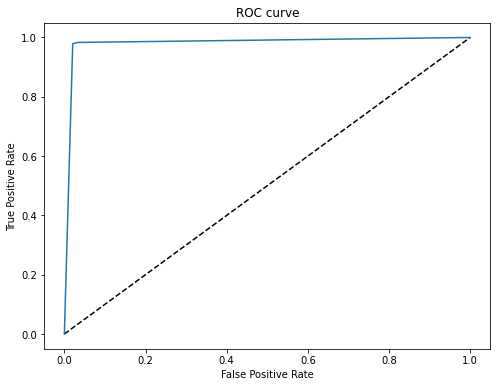

In [264]:
########################################
# Plot ROC curve
########################################
fig, ax=plt.subplots(1, 1, figsize=(8, 6))
fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
_=ax.plot([0, 1], [0, 1], 'k--')
_=ax.plot(fpr, tpr)
_=ax.set_xlabel('False Positive Rate')
_=ax.set_ylabel('True Positive Rate')
_=ax.set_title('ROC curve')
plt.show()

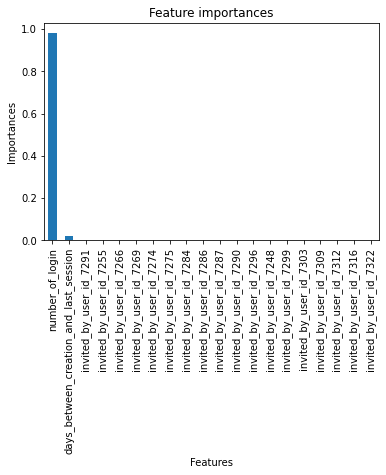

In [265]:
##########################################
# Feature importance
##########################################
pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:20].plot(kind='bar')
_=plt.xlabel('Features')
_=plt.ylabel('Importances')
_=plt.title('Feature importances')
plt.show()

### 3. Conclusion

It seems that the number of login of a user is the most effective factor to predict future user adoption, followed by the history of the user activity. I also investigated if some organizations or inviters are better to keep users adopted, but these factors are not signifcant (still, the users invited by user 7291, 7255, and 7266 are more likely to be adopted users). Further data including other activities of users besides login information, such as expenses of the users, would possibily be helpful for the prediction.